# Imagenette Dataset and VGG Transfer Learning

**This notebook demonstrates ability:** 

1. building a custom dataset using `torchvision.datasets.ImageFolder`,
2. building and training a model from scratch on that data, and
3. performing transfer learning by fine-tuning pretrained models to learn custom dataset.

In this notebook, we will play with some custom datasets that are subsets of larger, cumbersome ImageNet. The data are available from https://github.com/fastai/imagenette. We will explore the data. We train a simple CNN based model -`SmallVGG`- from scratch and explore Transfer Learning by fine-tuning the classifier layers while holding feature layers froze in a torchvision VGG model with pretrained weights. We assess performance of models and compare models based on loss, accuracy, confusion matrices, precision, recall and f1-score. 

<hr style="border:1px solid black">

## 0. Preliminaries

In [168]:
# Import statements

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from torchinfo import summary

import torchmetrics
#from torchmetrics import ConfusionMatrix

import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd

# import os
from pathlib import Path
import random
from PIL import Image

import mlxtend # to plot confusion matrix
from mlxtend.plotting import plot_confusion_matrix

from tqdm.auto import tqdm
from timeit import default_timer as timer

from typing import Tuple, Dict, List

# import helper_functions as hf
# import models as m

print(f"PyTorch version is: {torch.__version__}")
print(f"torchvision version is: {torchvision.__version__}")

PyTorch version is: 1.12.0
torchvision version is: 0.13.0


In [2]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is: {device}")

Device is: cpu


In [96]:
# Function to undo the normalization along each color channel (ie, "whitening") done in transforms before plotting.

def unnorm(img):

    """
         Undo normalizing transform for plotting. Do this before plotting image to get rid of errors about image clipping.
         Also normalized images are difficult to look at and seem saturated - although algorithms do better with this input.

         assuming that:
             MEAN = torch.tensor([0.485, 0.456, 0.406])
             STD = torch.tensor([0.229, 0.224, 0.225])
         
    """
    
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    return img * STD[:, None, None] + MEAN[:, None, None]

<hr style="border:1px solid black">

## 1. Explore Imagenette data

In [3]:
# Set up directory structure to data

data_path = Path('data')
image_path = data_path / 'imagenette2'

In [4]:
# Walk through file structure of downloaded dataset and print out some info

import os

def walk_through_dir(dir_path):
    """
        Walks through dir_path, returning its contents.
    """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 2 images in data/imagenette2.
There are 10 directories and 1 images in data/imagenette2/train.
There are 0 directories and 956 images in data/imagenette2/train/n03394916.
There are 0 directories and 961 images in data/imagenette2/train/n03417042.
There are 0 directories and 951 images in data/imagenette2/train/n03445777.
There are 0 directories and 955 images in data/imagenette2/train/n02102040.
There are 0 directories and 931 images in data/imagenette2/train/n03425413.
There are 0 directories and 960 images in data/imagenette2/train/n03888257.
There are 0 directories and 941 images in data/imagenette2/train/n03028079.
There are 0 directories and 858 images in data/imagenette2/train/n03000684.
There are 0 directories and 963 images in data/imagenette2/train/n01440764.
There are 0 directories and 993 images in data/imagenette2/train/n02979186.
There are 10 directories and 1 images in data/imagenette2/val.
There are 0 directories and 394 images in data/imagene

In [5]:
# Set up training and test paths

train_dir = image_path / "train"
test_dir = image_path / "val"

train_dir, test_dir

(PosixPath('data/imagenette2/train'), PosixPath('data/imagenette2/val'))

In [6]:
# Construct a list of all image files in train and test directory

train_image_paths = list(train_dir.glob('*/*.JPEG'))
test_image_paths = list(test_dir.glob('*/*.JPEG'))

print(f"Number of training, test images: {len(train_image_paths)}, {len(test_image_paths)}")

Number of training, test images: 9469, 3925


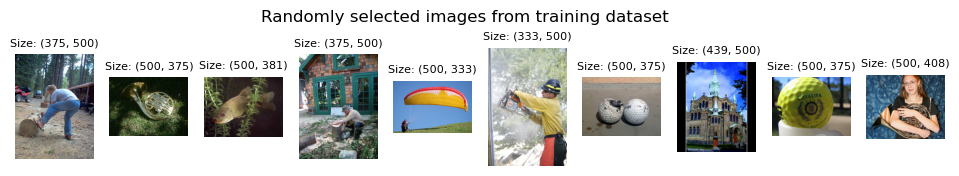

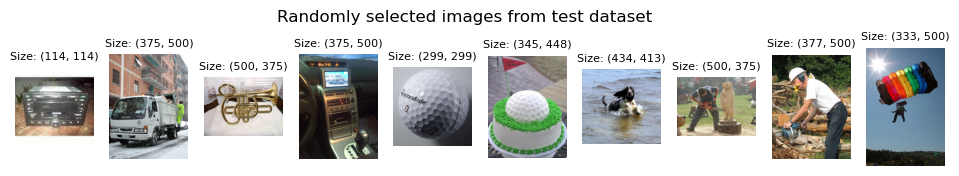

In [93]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_random_images(image_paths:list, n=3, transform=None, random_seed=None):
    """
        Selects random images from list of image paths and plots 1 row.
    """

    if random_seed:
        random.seed(random_seed)

    # Choose n image paths from all randomly.
    random_image_paths = random.sample(image_paths, k=n)
    
    for i,image_path in enumerate(random_image_paths):
        with Image.open(image_path) as f:

            if transform:
                im = unnorm(transform(f)).permute(1,2,0)
                title = f"Size: \n{im.shape}"
            else:
                im = f
                title = f"Size: {im.size}"
            
            ax = plt.subplot(1,n,i+1)
            ax.imshow(im)
            ax.set_title(title, fontsize=8)
            ax.axis(False)
            
# Run plot_random_images for 10 random datapoints in training and test data
plt.figure(figsize=(12,2))
plot_random_images(image_paths = train_image_paths, n=10)
plt.suptitle("Randomly selected images from training dataset");
#
plt.figure(figsize=(12,2))
plot_random_images(image_paths = test_image_paths, n=10)
plt.suptitle("Randomly selected images from test dataset");

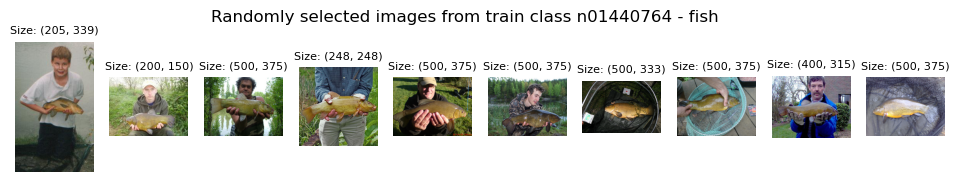

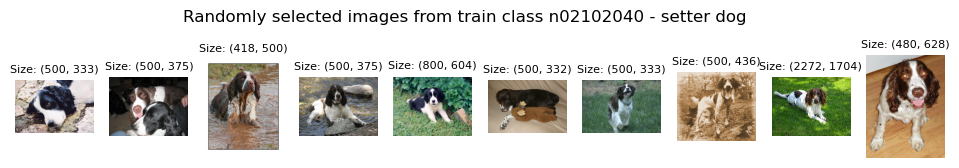

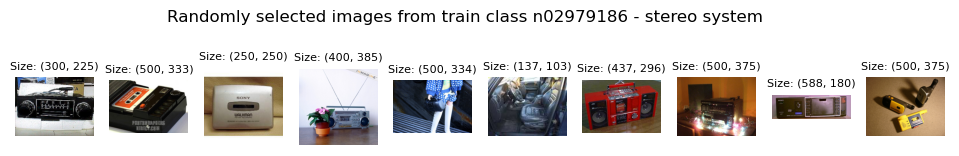

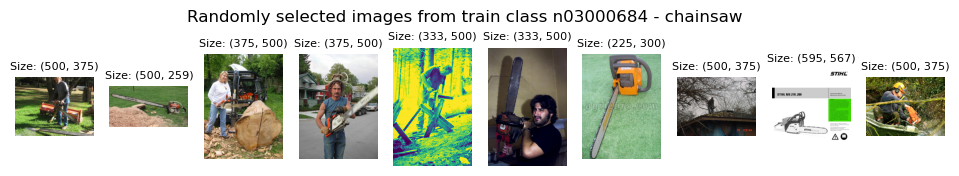

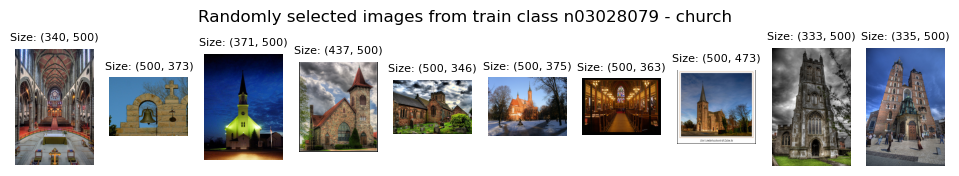

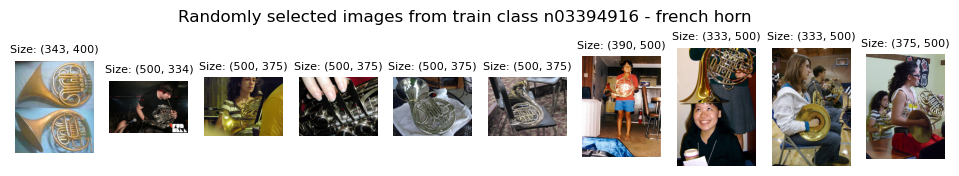

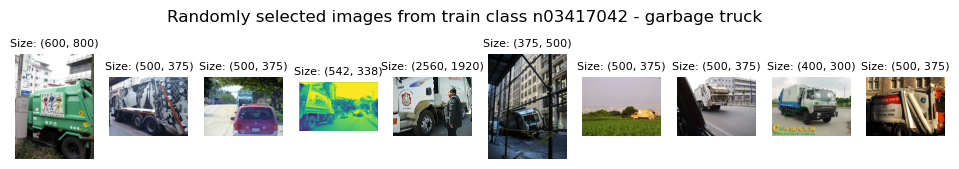

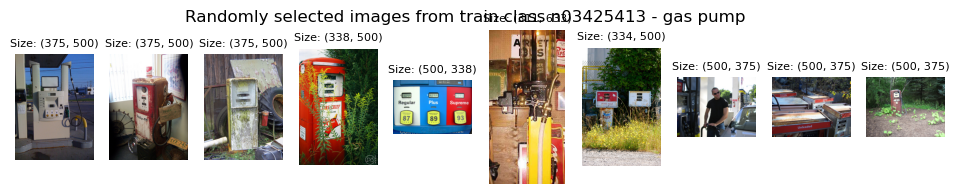

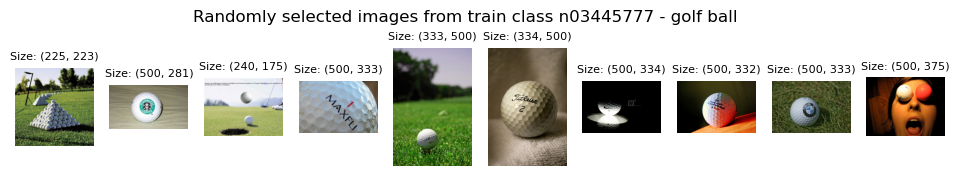

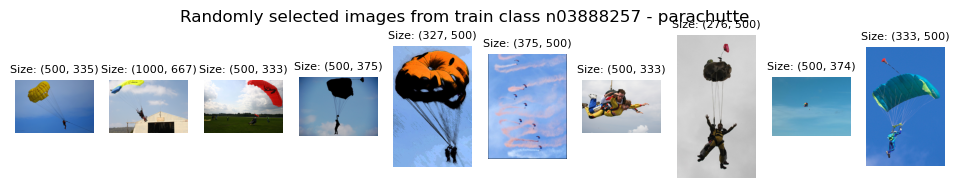

In [151]:
# Get class_names from directories and create dictionary to translate folder name into sensible class_name for label.

# Flags to plot example images from each class with class names as labels.
plot_train_classes = True
plot_test_classes = False

# Make a list of paths to each class_name directory inside training directory.
class_dir_list = list(train_dir.glob('n*'))

# Grab just class_name from full directory path
class_names_coded = sorted([item.stem for item in class_dir_list])

# Hand code class names by eye from plots made below.
class_names_decoded = ['fish', 'setter dog', 'stereo system', 'chainsaw', 'church', 
                       'french horn', 'garbage truck', 'gas pump', 'golf ball','parachutte' ]


# Plot several examples from each class in train data to associate names with them.
if plot_train_classes:
    for i, class_name in enumerate(class_names_coded):
    
        class_dir = train_dir / class_name
        class_image_paths = list(class_dir.glob('*.JPEG'))
    
        plt.figure(figsize=(12,2))
        plot_random_images(image_paths = class_image_paths, n=10)
        plt.suptitle(f"Randomly selected images from train class {class_name} - {class_names_decoded[i]}");


# Plot several examples from each class in test data to associate names with them.
if plot_test_classes:
    for i, class_name in enumerate(class_names_coded):
    
        class_dir = test_dir / class_name
        class_image_paths = list(class_dir.glob('*.JPEG'))
    
        plt.figure(figsize=(12,2))
        plot_random_images(image_paths = class_image_paths, n=10)
        plt.suptitle(f"Randomly selected images from test class {class_name} - {class_names_decoded[i]}");

<hr style="border:1px solid black">

## 2. Create transforms, dataset and dataloader for Imagenette data.

In [94]:
# 2a). Create data transforms that will be applied to training or test images with ImageFolder dataset

IMG_SIZE_TRANSFORM = 56 # was 224, but ran too slow

train_transform = transforms.Compose([
        # (1). Resize images 
        transforms.Resize(size=(IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM)),
        # (2). Flip the images randomly along horizontal
        transforms.RandomHorizontalFlip(p=0.5),
        # (3). Turn image into torch.Tensor
        transforms.ToTensor(),
        # (4). Normalize images as was done in models trained on ImageNet
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                             std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

test_transform = transforms.Compose([
        # (1). Resize images
        transforms.Resize(size=(IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM)),
        # (2). Turn image into torch.Tensor
        transforms.ToTensor(),
        # (3). Normalize images as was done in models trained on ImageNet
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                             std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

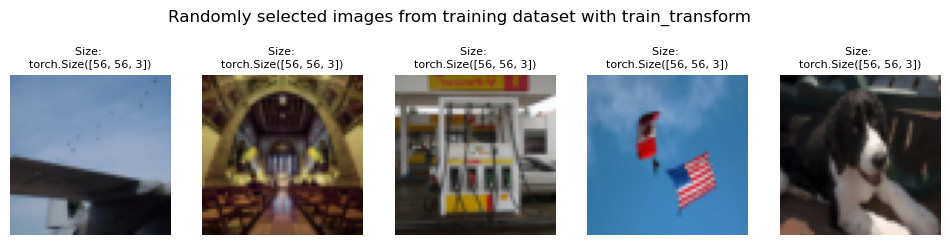

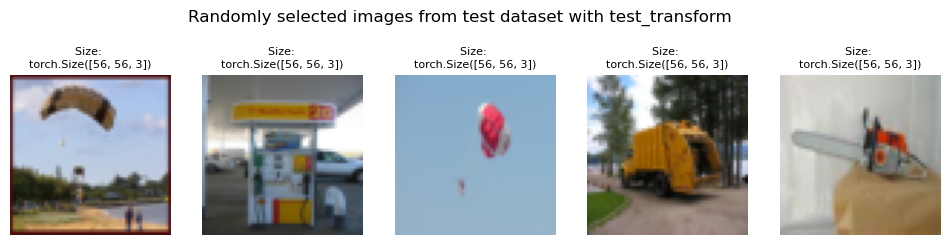

In [95]:
# Run plot_random_images for 10 random datapoints in training and test data
plt.figure(figsize=(12,3))
plot_random_images(image_paths = train_image_paths, n=5, transform=train_transform)
plt.suptitle("Randomly selected images from training dataset with train_transform");
#
plt.figure(figsize=(12,3))
plot_random_images(image_paths = test_image_paths, n=5, transform=test_transform)
plt.suptitle("Randomly selected images from test dataset with test_transform");

In [11]:
# 2b). Create dataset from train & test directories using ImageFolder
train_dataset = datasets.ImageFolder(root = str(train_dir),
                                     transform = train_transform,
                                     target_transform = None)

test_dataset = datasets.ImageFolder(root = str(test_dir),
                                    transform = test_transform,
                                    target_transform = None)

In [12]:
print(f"TRAIN DATASET:\n{train_dataset}") 
print(f"TEST DATASET:\n{test_dataset}") 

TRAIN DATASET:
Dataset ImageFolder
    Number of datapoints: 9469
    Root location: data/imagenette2/train
    StandardTransform
Transform: Compose(
               Resize(size=(56, 56), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
TEST DATASET:
Dataset ImageFolder
    Number of datapoints: 3925
    Root location: data/imagenette2/val
    StandardTransform
Transform: Compose(
               Resize(size=(56, 56), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [13]:
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of one sample: {len(train_dataset[0])}")
img, lbl = train_dataset[0]
print(f"Image shape: {img.shape}, & Label: {lbl}")

Length of train_dataset: 9469
Length of one sample: 2
Image shape: torch.Size([3, 56, 56]), & Label: 0


In [149]:
# for a,b,c,d in zip(train_dataset.classes, test_dataset.classes, class_names_coded, class_names_decoded):
#     print(a,b,c,d)

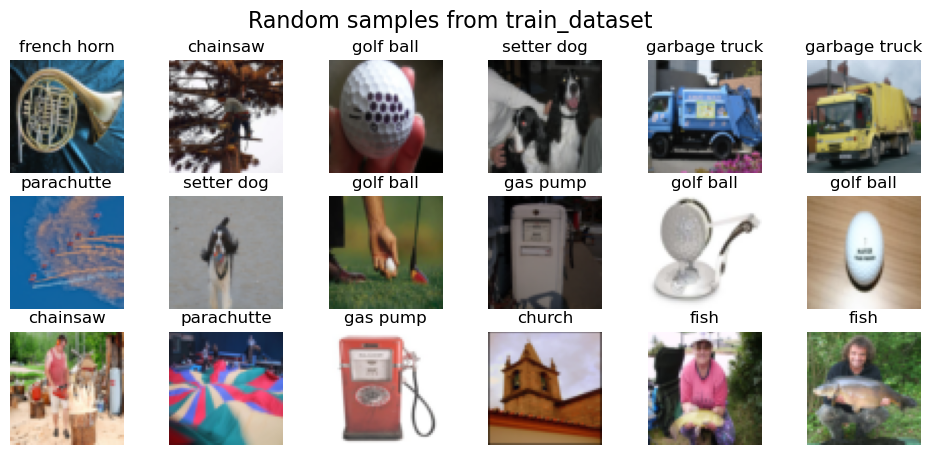

In [155]:
# Plot some random images from dataset with Label to see if they make sense.

def plot_images_and_labels_from_dataset(dataset: Dataset,
                                        grid: Tuple[int,int],
                                        class_names: List[str]):

    # Randomly sample index values to index into dataset
    indx = random.sample(range(len(dataset)), np.prod(grid))

    # Loop through indexes
    for i, ind in enumerate(indx):

        # Grab image and label data
        img,lbl = dataset[ind]

        # Plot data with label as title
        plt.subplot(grid[0], grid[1], i+1)
        plt.imshow(unnorm(img.cpu()).permute(1,2,0))
        plt.title(class_names[lbl])
        plt.axis(False)


plt.figure(figsize=(12,5))
plot_images_and_labels_from_dataset(dataset=train_dataset,
                                    grid=(3,6),
                                    class_names=class_names_decoded)
plt.suptitle(f"Random samples from train_dataset", fontsize=16);



In [128]:
# 2c). Create DataLoader for train & test datasets

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=0)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers=0) 

print(f"train_dataloader has {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"test_dataloader has {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_dataloader has 296 batches of size 32
test_dataloader has 123 batches of size 32


In [15]:
# Look at one batch of data from DataLoader

img_batch, lbl_batch = next(iter(train_dataloader))

print(f"Image Batch shape: {img_batch.shape}")
print(f"Label Batch shape: {lbl_batch.shape}")


Image Batch shape: torch.Size([32, 3, 56, 56])
Label Batch shape: torch.Size([32])


<hr style="border:1px solid black">

## 3. Build a SmallVGG model

In [16]:
# Class a model called VGG7 that interpolates between TinyVGG and VGG11. It will have 4 Conv2d layers 
# with ReLU and MaxPool2d operations interpsersed between them. It will have an AdaptiveAvgPool2d between
# the Convolution blocks and the Classifier block will have 3 Linear layers with ReLU and Dropout layers.

class SmallVGG(nn.Module):
    """
        This model started out as a VGG7 model (with 4 Convolutional layers in the 'features' section and 3 Linear 
        layers in the 'classifier' section. It was modeled after the VGG family of models in torchvision.models.
            (ie.)
            >> weights = torchvision.models.VGG##_BN_Weights.DEFAULT
            >> model_TL = torchvision.models.vgg##_bn(weights=weights) # where ## = {11,13,16,19}

        But, that model was too large to train in a reasonable amount of time on my laptop 'cpu' so I cut it back to
        have fewer layers (2 Conv and 2 Linear) with fewer channels in each layer. It trains and receives ~70% accuracy
        on imagenette dataset when trained from scratch on it.

            Use it like:
            >> model = SmallVGG()
            >> y_logits = model(X)
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=16, 
                               kernel_size=(3, 3), 
                               stride=(1, 1), 
                               padding=(1, 1))

        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32, 
                               kernel_size=(3, 3), 
                               stride=(1, 1), 
                               padding=(1, 1)) 

        # self.conv3 = nn.Conv2d(in_channels=128, 
        #                        out_channels=256, 
        #                        kernel_size=(3, 3), 
        #                        stride=(1, 1), 
        #                        padding=(1, 1)) 

        # self.conv4 = nn.Conv2d(in_channels=256, 
        #                        out_channels=512, 
        #                        kernel_size=(3, 3), 
        #                        stride=(1, 1), 
        #                        padding=(1, 1)) 

        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=16)

        self.batchnorm2 = nn.BatchNorm2d(num_features=32)

        # self.batchnorm3 = nn.BatchNorm2d(num_features=256)

        # self.batchnorm4 = nn.BatchNorm2d(num_features=512)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.linear1 = nn.Linear(in_features=32*7*7, out_features=4096, bias=True)

        #self.linear2 = nn.Linear(in_features=4096, out_features=4096, bias=True)

        self.linear3 = nn.Linear(in_features=4096, out_features=1000, bias=True)

        self.dropout = nn.Dropout()

        self.flatten = nn.Flatten()


    def forward(self, x: torch.Tensor, verbose: bool = False) -> torch.Tensor:
        # Convolutional Block #1
        if verbose: print(f"Input shape: {x.shape}")
        z = self.conv1(x)
        if verbose: print(f"After conv1, shape: {z.shape}")
        z = self.batchnorm1(z)
        if verbose: print(f"After batchnorm1, shape: {z.shape}")
        z = self.relu(z)
        if verbose: print(f"After relu1, shape: {z.shape}")
        z = self.maxpool(z)
        if verbose: print(f"After maxpool1, shape: {z.shape} \n")

        # Convolutional Block #2
        z = self.conv2(z)
        if verbose: print(f"After conv2, shape: {z.shape}")
        z = self.batchnorm2(z)
        if verbose: print(f"After batchnorm2, shape: {z.shape}")
        z = self.relu(z)
        if verbose: print(f"After relu2, shape: {z.shape}")
        z = self.maxpool(z)
        if verbose: print(f"After maxpool2, shape: {z.shape} \n")

        # # Convolutional Block #3
        # z = self.conv3(z)
        # if verbose: print(f"After conv3, shape: {z.shape}")
        # z = self.batchnorm3(z)
        # if verbose: print(f"After batchnorm3, shape: {z.shape}")
        # z = self.relu(z)
        # if verbose: print(f"After relu3, shape: {z.shape}")
        # z = self.maxpool(z)
        # if verbose: print(f"After maxpool3, shape: {z.shape} \n")

        # # Convolutional Block #4
        # z = self.conv4(z)
        # if verbose: print(f"After conv4, shape: {z.shape}")
        # z = self.batchnorm4(z)
        # if verbose: print(f"After batchnorm4, shape: {z.shape}")
        # z = self.relu(z)
        # if verbose: print(f"After relu4, shape: {z.shape}")
        # z = self.maxpool(z)
        # if verbose: print(f"After maxpool4, shape: {z.shape} \n")

        # Average Pooling
        z = self.avgpool(z)
        if verbose: print(f"After avgpool, shape: {z.shape} \n")

        z = self.flatten(z)
        if verbose: print(f"After flatten, shape: {z.shape} \n")

        # Classifier Block #1
        z = self.dropout(self.relu( self.linear1(z) ) )
        if verbose: print(f"After classifer1, shape: {z.shape} \n")

        # # Classifier Block #2
        # z = self.dropout( self.relu( self.linear2(z) ) )
        # if verbose: print(f"After classifer2, shape: {z.shape} \n")

        # Classifier Block #3
        z = self.linear3(z)
        if verbose: print(f"Output, shape: {z.shape}")

        return z

In [17]:
# Pass a batch of images through model to compare shapes with shapes that torchvision's VGG model produces.

model1 = SmallVGG().to(device)

model1.eval()

with torch.inference_mode():
    y = model1(img_batch, verbose=True)


Input shape: torch.Size([32, 3, 56, 56])
After conv1, shape: torch.Size([32, 16, 56, 56])
After batchnorm1, shape: torch.Size([32, 16, 56, 56])
After relu1, shape: torch.Size([32, 16, 56, 56])
After maxpool1, shape: torch.Size([32, 16, 28, 28]) 

After conv2, shape: torch.Size([32, 32, 28, 28])
After batchnorm2, shape: torch.Size([32, 32, 28, 28])
After relu2, shape: torch.Size([32, 32, 28, 28])
After maxpool2, shape: torch.Size([32, 32, 14, 14]) 

After avgpool, shape: torch.Size([32, 32, 7, 7]) 

After flatten, shape: torch.Size([32, 1568]) 

After classifer1, shape: torch.Size([32, 4096]) 

Output, shape: torch.Size([32, 1000])


In [18]:
# Could apply TinyVGG model to imagenette2 dataset.

if True:
    from models import TinyVGG_CIFAR

    model2 = TinyVGG_CIFAR(input_shape=3,
                           hidden_units=16,
                           output_shape=1000,
                           linear_scaler=14).to(device)
    
    print(model2)

TinyVGG_CIFAR(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1000, bias=True)
  )
)


### Use torchinfo's summary to display model information.

In [19]:
summary(model1, input_size = [32, 3, IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM],
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SmallVGG (SmallVGG)                      [32, 3, 56, 56]      [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 56, 56]      [32, 16, 56, 56]     448                  True
├─BatchNorm2d (batchnorm1)               [32, 16, 56, 56]     [32, 16, 56, 56]     32                   True
├─ReLU (relu)                            [32, 16, 56, 56]     [32, 16, 56, 56]     --                   --
├─MaxPool2d (maxpool)                    [32, 16, 56, 56]     [32, 16, 28, 28]     --                   --
├─Conv2d (conv2)                         [32, 16, 28, 28]     [32, 32, 28, 28]     4,640                True
├─BatchNorm2d (batchnorm2)               [32, 32, 28, 28]     [32, 32, 28, 28]     64                   True
├─ReLU (relu)                            [32, 32, 28, 28]     [32, 32, 28, 28]     --                   --
├─MaxPool2d (maxpool

Note: This summary is not so helpful for SmallVGG because I ordered things in the `forward` method instead of using Sequential blocks in the `__init__` method. I don't need to have these verbose-flag print statements in order to get shapes of input and output. Lesson learned.

In [20]:
summary(model2, input_size = [32, 3, IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM],
                col_names=["input_size", "output_size", "num_params", "trainable"],
                col_width=20,
                row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyVGG_CIFAR (TinyVGG_CIFAR)            [32, 3, 56, 56]      [32, 1000]           --                   True
├─Sequential (conv_block1)               [32, 3, 56, 56]      [32, 16, 28, 28]     --                   True
│    └─Conv2d (0)                        [32, 3, 56, 56]      [32, 16, 56, 56]     448                  True
│    └─ReLU (1)                          [32, 16, 56, 56]     [32, 16, 56, 56]     --                   --
│    └─Conv2d (2)                        [32, 16, 56, 56]     [32, 16, 56, 56]     2,320                True
│    └─ReLU (3)                          [32, 16, 56, 56]     [32, 16, 56, 56]     --                   --
│    └─MaxPool2d (4)                     [32, 16, 56, 56]     [32, 16, 28, 28]     --                   --
├─Sequential (conv_block2)               [32, 16, 28, 28]     [32, 16, 14, 14]     --                   True
│    └─Conv2d (0)   

<hr style="border:1px solid black">

## 4. Train TinyVGG and SmallVGG models on imagenette2 data

In [21]:
# Define training step

def train_step(model: nn.Module,
               dataloader: DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: nn.Module = nn.CrossEntropyLoss(),
               device: torch.device = device):

    """
    Training step to train a multiclass classification model. Is called within training loop
    over epochs and a loop over batches in dataloader as well.

    :args:
        :model: - torch model that will learn params on training data - nn.Module
        :dataloader: - DataLoader iterable from torch.utils.data to feed in data by the batch.
        :optimizer: - optimizer to perform gradient descent step. torch.optim.Optimizer
        :loss_fn: - loss function used to compare model logits to ground truth labels
            to perform backprop & gradient descent. nn.Module
            Note: for multiclass classification problems, loss functions is nn.CrossEntropyLoss().
        :device: - device that code is run on ("cuda" or "cpu")

    :returns:
        :train_loss: - average loss per batch across all batches in training dataset
        :train_acc:  - average accuracy per batch across all batches in training dataset

    :example:
        train_loss, train_acc = train_step(model=model0,
                                           dataloader=train_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           device=device)
    """

    # Set model in training mode
    model.train()

    # Initialize loss and accuracy
    train_loss, train_acc = 0, 0

    # Loop through batches in training dataloader
    for batch, (X, y_labels) in enumerate(dataloader):

        # Put data on device
        X, y_labels = X.to(device), y_labels.to(device)

        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y_labels)
        train_loss += loss

        # Convert raw logits to predictions
        y_preds = y_logits.softmax(dim=1).argmax(dim=1)
        
        # Calculate accuracy
        acc = (y_preds==y_labels).sum()/len(y_labels)
        train_acc += acc

        # Zero gradients
        optimizer.zero_grad()

        # Backprogagate gradients
        loss.backward()

        # Gradient descent
        optimizer.step()

    # Compute average loss, accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

In [22]:
# Define test step

def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module = nn.CrossEntropyLoss(),
              device: torch.device = device):

    """
    Compute loss and accuracy on test data without updating model params for multiclass
    classification model. Called within training loop.

    :args:
        :model: - torch model that will learn params on training data - nn.Module
        :dataloader: - DataLoader iterable from torch.utils.data to feed in data by the batch.
        :loss_fn: - loss function used to compare model logits to ground truth labels
            to perform backprop & gradient descent. nn.Module
            Note: for multiclass classification problems, loss functions is nn.CrossEntropyLoss().
        :device: - device that code is run on ("cuda" or "cpu")

    :returns:
        :test_loss: - average loss per batch across all batches in test dataset
        :test_acc:  - average accuracy per batch across all batches in test dataset

    :example:
        test_loss, test_acc = test_step(model=model0,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
    """

    # initialize loss and accuracy
    test_loss, test_acc = 0, 0

    # put model in evaluation and inference mode
    model.eval()
    with torch.inference_mode():

        # Loop through batches in test dataloader
        for batch, (X, y_labels) in enumerate(dataloader):
    
            # Put data on device
            X, y_labels = X.to(device), y_labels.to(device)
        
            # Forward pass
            y_logits = model(X)

            # Calculate loss
            loss = loss_fn(y_logits, y_labels)
            test_loss += loss
    
            # Convert raw logits to predictions
            y_preds = y_logits.softmax(dim=1).argmax(dim=1)
            
            # Calculate accuracy
            acc = (y_preds==y_labels).sum()/len(y_labels)
            test_acc += acc

        # Compute average loss, accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [23]:
# Define training loop

def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = device):
    
    """
    Train model on data inside train_dataloader for prescribed number of epochs on prescribed device and returns
    a results dictionary containing train and test loss and accuracy for each epoch of training.

    :args:
        :model: - model to be trained (nn.Module object)
        :train_dataloader: - training data (torch.utils.data.DataLoader object)
        :test_dataloader:  - test data (torch.utils.data.DataLoader object)
        :optimizer: - optimizer like SGD or Adam (torch.optim.Optimizer object)
        :loss_fn: - loss function - CrossEntropyLoss for multiclass classification (nn.Module object)
        :epochs: - integer number of epochs to train for. (number of times to completely loop through all training data).
        :device: - either "cuda" for GPU or "cpu" for CPU. (torch.device object)


    :returns:
        :results: - dictionary containing lists for 'train_loss', 'test_loss', 'train_acc', 'test_acc' with one value
                    for each epoch of training

    :example:
        results0 = train(model=model0,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         optimizer=optimizer,
                         loss_fn=nn.CrossEntropyLoss(),
                         epochs=5,
                         device=device)
    """

    # Set up empty results dictionary to be filled during training
    results = {'train_loss':[],
               'test_loss':[],
               'train_acc':[],
               'test_acc':[],
               'train_time':[]}

    # Loop through all training data for each epoch
    for epoch in tqdm(range(epochs)):

        # Start timer to record how long each training epoch takes
        epoch_st = timer()

        # Train step
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           device=device)

        # Test step
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Record how long epoch took
        epoch_fin = timer()
        train_time = epoch_fin - epoch_st

        # Fill results dictionary with results
        results['train_loss'].append(train_loss.item())
        results['test_loss'].append(test_loss.item())
        results['train_acc'].append(train_acc.item())
        results['test_acc'].append(test_acc.item())
        results['train_time'].append(train_time)

        # Print to screen whats happening
        print(f"Epoch: {epoch:3d} | Loss (train,test): {train_loss:.5f}, {test_loss:.5f} | " + 
              f"Accuracy (train,test): {train_acc:.3f}, {test_acc:.3f} | Train time: {train_time:.5f} sec")

    return results
    

In [24]:
# Define loss function, optimizer, hyperparameters, etc.
LEARNING_RATE = 0.1
EPOCHS = 7

In [25]:
# Train SmallVGG model from scratch directly on Imagenette2 dataset

results1 = train(model=model1,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=torch.optim.SGD(params=model1.parameters(),
                                           lr=LEARNING_RATE),
                 loss_fn=nn.CrossEntropyLoss(),
                 epochs=EPOCHS,
                 device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0 | Loss (train,test): 2.09117, 1.60811 | Accuracy (train,test): 0.356, 0.458 | Train time: 79.60147 sec
Epoch:   1 | Loss (train,test): 1.44297, 1.34163 | Accuracy (train,test): 0.520, 0.553 | Train time: 81.66769 sec
Epoch:   2 | Loss (train,test): 1.21025, 1.12486 | Accuracy (train,test): 0.606, 0.651 | Train time: 79.55147 sec
Epoch:   3 | Loss (train,test): 1.08264, 1.06165 | Accuracy (train,test): 0.648, 0.665 | Train time: 77.63717 sec
Epoch:   4 | Loss (train,test): 0.99670, 1.03064 | Accuracy (train,test): 0.679, 0.671 | Train time: 77.51004 sec
Epoch:   5 | Loss (train,test): 0.91910, 1.10148 | Accuracy (train,test): 0.701, 0.650 | Train time: 79.23764 sec
Epoch:   6 | Loss (train,test): 0.84670, 1.03917 | Accuracy (train,test): 0.722, 0.679 | Train time: 77.24116 sec


In [26]:
# Train TinyVGG model directly on Imagenette2 dataset

if False:
    results2 = train(model=model2,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=torch.optim.SGD(params=model2.parameters(),
                                               lr=LEARNING_RATE),
                     loss_fn=nn.CrossEntropyLoss(),
                     epochs=EPOCHS,
                     device=device)

print("Not sure why, but TinyVGG model doesn't seem to learn here. More interesting things to do... like Transfer Learning.")


Not sure why, but TinyVGG model doesn't seem to learn here. More interesting things to do... like Transfer Learning.


<hr style="border:1px solid black">

## 5. Visualize results with SmallVGG model trained from scratch on Imagenette2 dataset

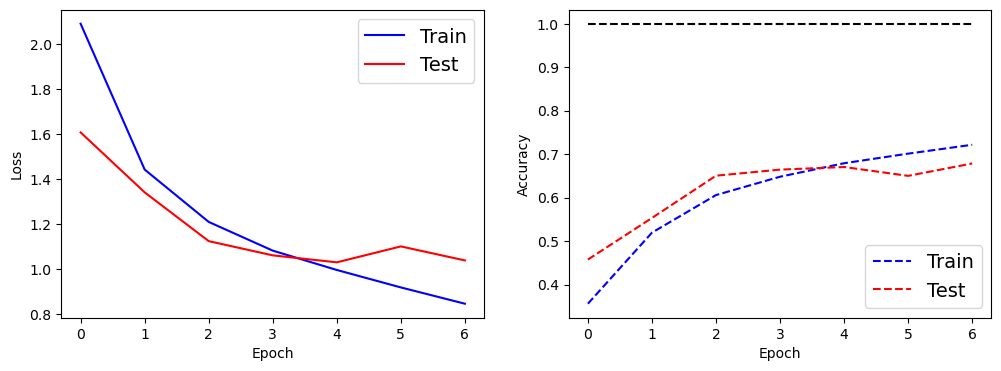

In [45]:
def plot_loss(results: Dict[str, List[float]], y_scale='linear'):
    """
    Plot training loss and test loss against epoch during training loop.

    :args:
        :results: dictionary containing ['train_loss', 'test_loss', 'train_acc', 'test_acc', 'train_time']
        
    :return: None
    """

    pass

    epoch = range(len(results['train_loss']))
    #
    # Plot loss on one subplot
    plt.subplot(1,2,1)
    plt.plot(epoch, results['train_loss'], c='b', linestyle='-', label='Train')
    plt.plot(epoch, results['test_loss'], c='r', linestyle='-', label='Test')
    plt.yscale(y_scale)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(prop={"size": 14})
    #
    # plot accuracy on second subplot
    plt.subplot(1,2,2)
    plt.plot(epoch, np.ones_like(epoch), c='k', linestyle='--')
    plt.plot(epoch, results['train_acc'], c='b', linestyle='--', label='Train')
    plt.plot(epoch, results['test_acc'], c='r', linestyle='--', label='Test')
    plt.yscale(y_scale)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(prop={"size": 14})
    

plt.figure(figsize=(12,4))
plot_loss(results1)

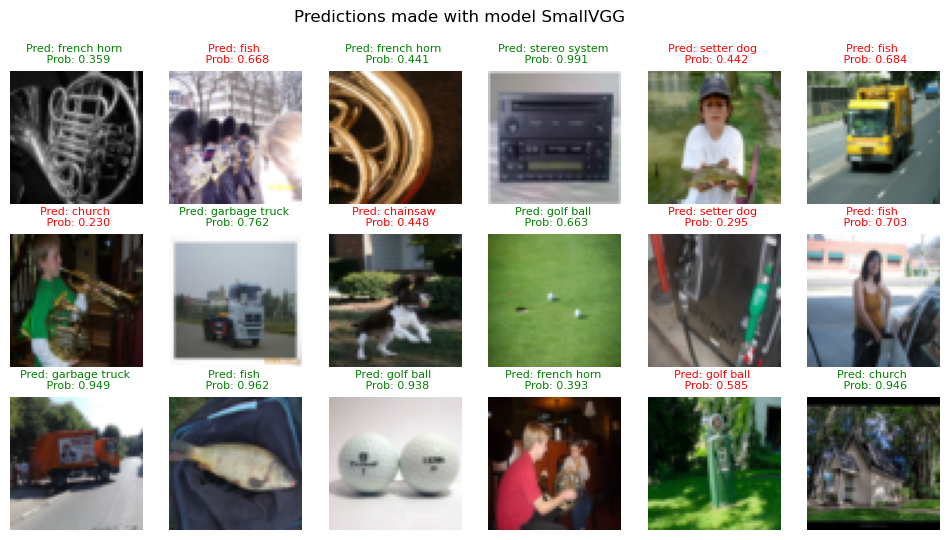

In [157]:
def plot_predictions(model: nn.Module,
                     dataset: Dataset,
                     grid: Tuple[int,int],
                     class_names: List[str],
                     device: torch.device = device):
    
    """

    """

    # Grab random index values to take samples from dataset
    indx = random.sample(range(len(dataset)), np.prod(grid)) 

    # Loop through random data samples
    for i, ind in enumerate(indx):
        img, lbl = dataset[ind]

        model.eval()
        with torch.inference_mode():
            y_logit = model( img.unsqueeze(0).to(device) )

        # Convert raw model output to probability and prediction
        y_prob = y_logit.softmax(dim=1)
        y_pred = y_prob.argmax(dim=1)#.item()
    
        # Plot
        plt.subplot(grid[0],grid[1],i+1)
        plt.imshow(unnorm(img).squeeze().permute(1,2,0))
        #
        if class_names:
            title = f"Pred: {class_names[y_pred.cpu()]} \n Prob: {y_prob.max().cpu():.3f}"
        else: 
            title = f"Pred: {y_pred.cpu().item()} | Lbl: {lbl} \n Prob: {y_prob.max().cpu():.3f}"
        #
        if y_pred==lbl:
            title_color='g'
        else:
            title_color='r'
        
        plt.title(title, fontsize=8, c=title_color)
        plt.axis(False);


plt.figure(figsize=(12,6))
plot_predictions(model=model1,
                 dataset=test_dataset,
                 grid=(3,6),
                 class_names=class_names_decoded,
                 device=device)
plt.suptitle(f"Predictions made with model {model1.__class__.__name__}");


In [188]:
# Make predictions across whole test_data set.

def predict(model: nn.Module,
            dataloader: DataLoader,
            device: torch.device):

    """
    Make predictions on all data in specified dataloader with specified model.

    :args:
        :model:
        :dataloader:
        :device:

    :returns:
        :y_preds_tensor:

    :example:
        y_preds_tensor = predict(model=model1,
                         dataloader=test_dataloader,
                         device=device)
    
    """

    print(f"Making predictions on entire dataset {dataloader.dataset.root} with model {model.__class__.__name__}.")
    
    y_preds = []

    # put model in evaluation / inference mode
    model.eval()
    with torch.inference_mode():

        # Loop through batches in dataloader
        for X, y in tqdm(dataloader):
            
            # 1. Send data to device
            X, y = X.to(device), y.to(device)
            
            # 2. Forward pass
            y_logit = model(X) 
            
            # 3. Convert logit -> probability -> prediction.
            y_prob = y_logit.softmax(dim=1)
            y_pred = y_prob.argmax(dim=1)
            
            y_preds.append(y_pred.cpu())
            
        y_preds_tensor = torch.cat(y_preds)

    return y_preds_tensor


y_preds_tensor = predict(model=model1,
                         dataloader=test_dataloader,
                         device=device)



Making predictions on entire dataset data/imagenette2/val with model SmallVGG.


  0%|          | 0/123 [00:00<?, ?it/s]

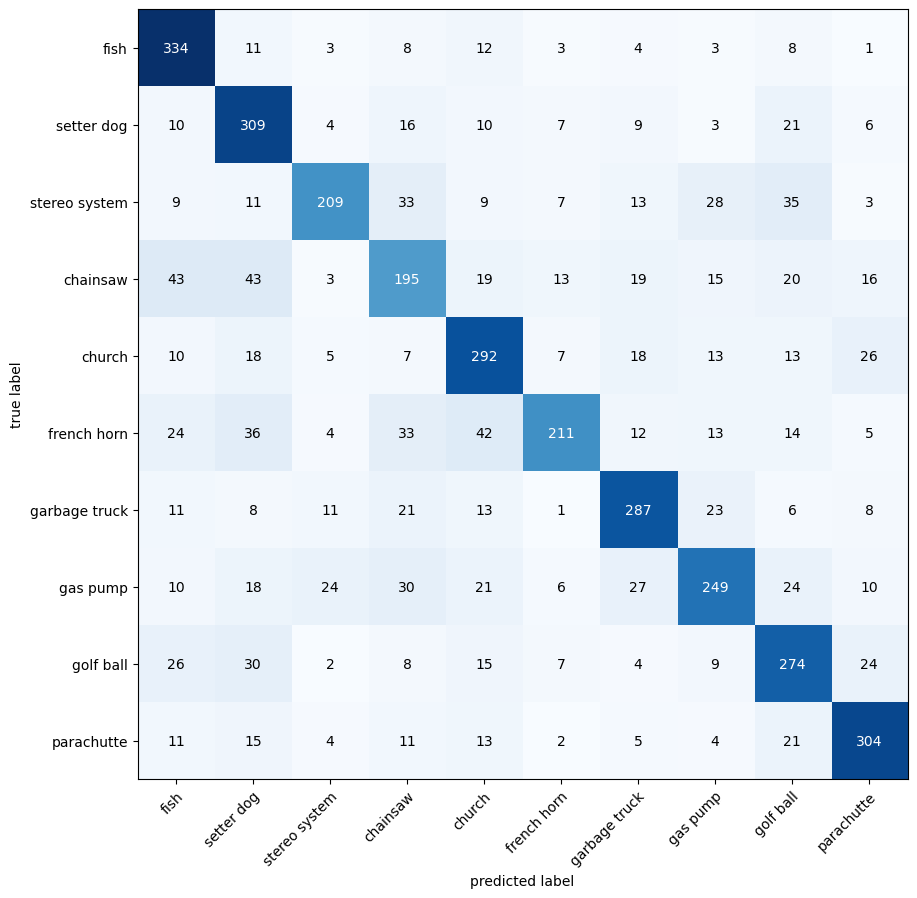

In [178]:
# Plot confusion matrix using mlxtend and torchmetrics

confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=len(class_names_decoded))

confmat_tensor = confmat(preds=y_preds_tensor, 
                         target=torch.tensor(test_dataset.targets))

fig,ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                               class_names=class_names_decoded,
                               figsize=(14,10))

In [176]:
# Gather up Precision, Recall and F1-score.

f1_score = torchmetrics.F1Score(task='multiclass', num_classes=len(class_names_decoded))

f1 = f1_score(preds=y_preds_tensor, 
              target=torch.tensor(test_dataset.targets)).item()

precision = torchmetrics.Precision(task='multiclass', num_classes=len(class_names_decoded))

prec = precision(preds=y_preds_tensor, 
                 target=torch.tensor(test_dataset.targets)).item()

recall = torchmetrics.Recall(task='multiclass', num_classes=len(class_names_decoded))

rec = recall(preds=y_preds_tensor, 
             target=torch.tensor(test_dataset.targets)).item()

print(f1, prec, rec)

tensor(0.6787) tensor(0.6787) tensor(0.6787)


<hr style="border:1px solid black">

## 6. Transfer Learning: Look at torchvision models with pretrained weights

In [30]:
# Can use any of VGG{11,13,16,19} models with pretrained weights from torchvision models archive.
#     They are all same basic architecture, just deeper with increasing number.

if True:
    weights = torchvision.models.VGG11_BN_Weights.DEFAULT
    class_names_TL  = weights.meta['categories']
    
    model_TL = torchvision.models.vgg11_bn(weights=weights)
    print(model_TL)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [31]:
# OR can use resnet model with pretrained weights from torchvision models archive.
#     Can be resnet{18,34,50,101,152} for deeper models with increasing number.

if False:
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    class_names_TL  = weights.meta['categories']
    
    model_TL = torchvision.models.resnet50(weights=weights)
    print(f"Model for Transfer Learning is: \n{model_TL}")

In [32]:
summary(model_TL, input_size = [32, 3, IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 56, 56]      [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 56, 56]      [32, 512, 1, 1]      --                   True
│    └─Conv2d (0)                        [32, 3, 56, 56]      [32, 64, 56, 56]     1,792                True
│    └─BatchNorm2d (1)                   [32, 64, 56, 56]     [32, 64, 56, 56]     128                  True
│    └─ReLU (2)                          [32, 64, 56, 56]     [32, 64, 56, 56]     --                   --
│    └─MaxPool2d (3)                     [32, 64, 56, 56]     [32, 64, 28, 28]     --                   --
│    └─Conv2d (4)                        [32, 64, 28, 28]     [32, 128, 28, 28]    73,856               True
│    └─BatchNorm2d (5)                   [32, 128, 28, 28]    [32, 128, 28, 28]    256                  True
│    └─ReLU (6)   

In [33]:
# Can freeze parameters in feature layers so they dont change during training...

for param in model_TL.features.parameters():
    param.requires_grad = False

In [34]:
# Now adapt classifer block to have correct number of outputs (10, instead of 1000) for this dataset.
HIDDEN_CLASSIFIER_UNITS = 128 # was 4096
model_TL.classifier = nn.Sequential(
                                nn.Linear(in_features=25088, out_features=HIDDEN_CLASSIFIER_UNITS, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                #nn.Linear(in_features=HIDDEN_CLASSIFIER_UNITS, out_features=HIDDEN_CLASSIFIER_UNITS, bias=True),
                                #nn.ReLU(inplace=True),
                                #nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=HIDDEN_CLASSIFIER_UNITS, out_features=10, bias=True)
                                  )


In [35]:
summary(model_TL, input_size = [32, 3, IMG_SIZE_TRANSFORM, IMG_SIZE_TRANSFORM],
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 56, 56]      [32, 10]             --                   Partial
├─Sequential (features)                  [32, 3, 56, 56]      [32, 512, 1, 1]      --                   False
│    └─Conv2d (0)                        [32, 3, 56, 56]      [32, 64, 56, 56]     (1,792)              False
│    └─BatchNorm2d (1)                   [32, 64, 56, 56]     [32, 64, 56, 56]     (128)                False
│    └─ReLU (2)                          [32, 64, 56, 56]     [32, 64, 56, 56]     --                   --
│    └─MaxPool2d (3)                     [32, 64, 56, 56]     [32, 64, 28, 28]     --                   --
│    └─Conv2d (4)                        [32, 64, 28, 28]     [32, 128, 28, 28]    (73,856)             False
│    └─BatchNorm2d (5)                   [32, 128, 28, 28]    [32, 128, 28, 28]    (256)                False
│    └─ReL

In [36]:
# Train adapted classifier layer of pretrained VGG11 model with feature layers frozen on Imagenette2 dataset

results2 = train(model=model_TL,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=torch.optim.SGD(params=model_TL.parameters(),
                                           lr=LEARNING_RATE),
                 loss_fn=nn.CrossEntropyLoss(),
                 epochs=EPOCHS,
                 device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch:   0 | Loss (train,test): 1.19922, 0.88487 | Accuracy (train,test): 0.620, 0.717 | Train time: 127.10400 sec
Epoch:   1 | Loss (train,test): 1.00421, 0.81695 | Accuracy (train,test): 0.677, 0.741 | Train time: 130.80532 sec
Epoch:   2 | Loss (train,test): 0.93793, 0.85060 | Accuracy (train,test): 0.692, 0.724 | Train time: 128.45884 sec
Epoch:   3 | Loss (train,test): 0.91079, 0.81209 | Accuracy (train,test): 0.708, 0.735 | Train time: 129.47570 sec
Epoch:   4 | Loss (train,test): 0.88202, 0.82712 | Accuracy (train,test): 0.713, 0.738 | Train time: 129.86882 sec
Epoch:   5 | Loss (train,test): 0.85315, 0.81693 | Accuracy (train,test): 0.723, 0.742 | Train time: 129.42458 sec
Epoch:   6 | Loss (train,test): 0.86451, 0.81892 | Accuracy (train,test): 0.719, 0.745 | Train time: 127.53460 sec


<hr style="border:1px solid black">

## 6b. Visualize Results with and evaluate performance of Transfer Learning models

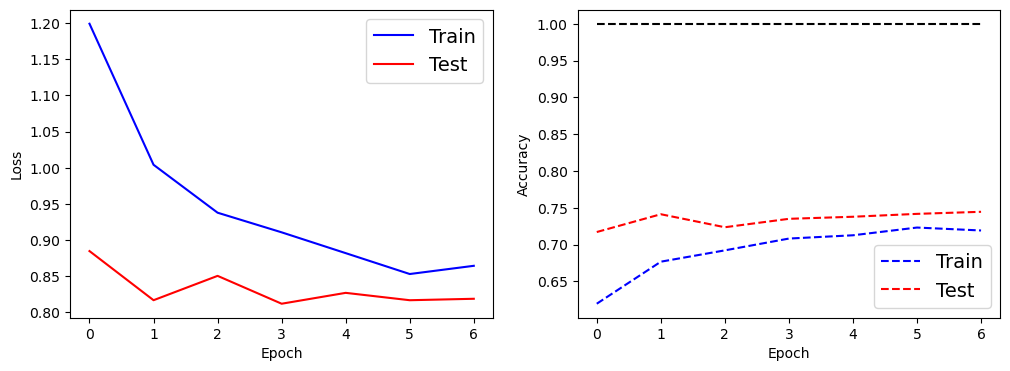

In [84]:
# Plot loss and accuracy during training for pretrained VGG11 model.

plt.figure(figsize=(12,4))
plot_loss(results2)

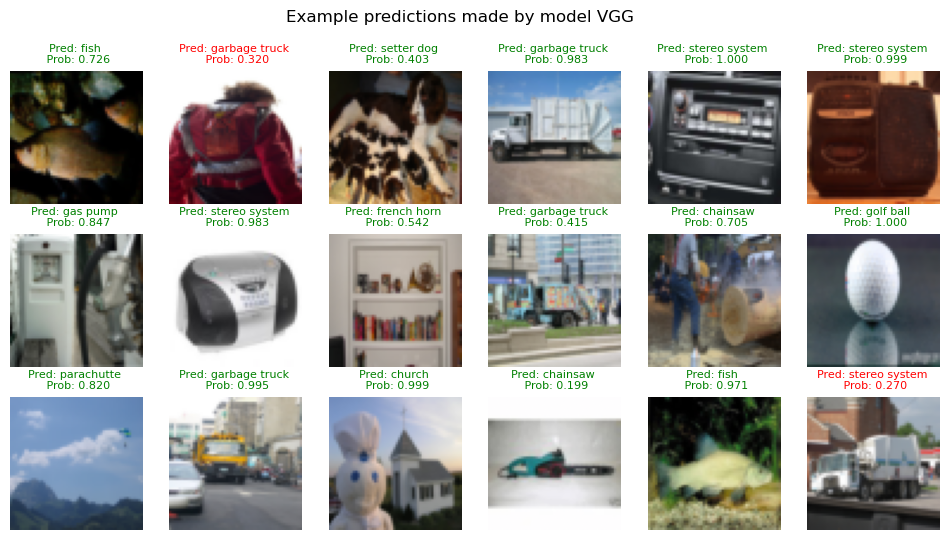

In [182]:
# Make predictions with VGG11 model finetuned on this dataset

plt.figure(figsize=(12,6))
plot_predictions(model=model_TL,
                 dataset=test_dataset,
                 grid=(3,6),
                 class_names=class_names_decoded,
                 device=device)
plt.suptitle(f"Example predictions made by model {model_TL.__class__.__name__}");

In [189]:
# Make predictions on test_dataset with VGG11 model

y_preds_tensor = predict(model=model_TL,
                         dataloader=test_dataloader,
                         device=device)

Making predictions on entire dataset data/imagenette2/val with model VGG.


  0%|          | 0/123 [00:00<?, ?it/s]

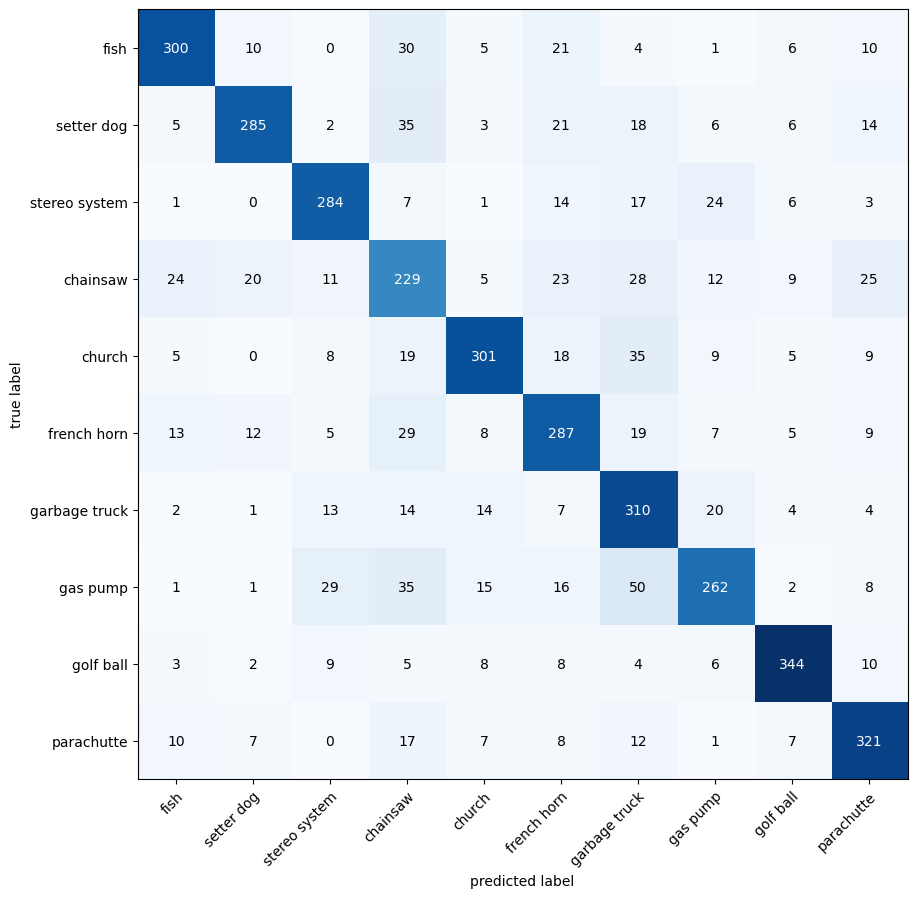

In [190]:
# Plot confusion matrix using mlxtend and torchmetrics

confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=len(class_names_decoded))

confmat_tensor = confmat(preds=y_preds_tensor, 
                         target=torch.tensor(test_dataset.targets))

fig,ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                               class_names=class_names_decoded,
                               figsize=(14,10))

In [191]:
# Gather up Precision, Recall and F1-score.

f1_score = torchmetrics.F1Score(task='multiclass', num_classes=len(class_names_decoded))

f1 = f1_score(preds=y_preds_tensor, 
              target=torch.tensor(test_dataset.targets)).item()

precision = torchmetrics.Precision(task='multiclass', num_classes=len(class_names_decoded))

prec = precision(preds=y_preds_tensor, 
                 target=torch.tensor(test_dataset.targets)).item()

recall = torchmetrics.Recall(task='multiclass', num_classes=len(class_names_decoded))

rec = recall(preds=y_preds_tensor, 
             target=torch.tensor(test_dataset.targets)).item()

print(f1, prec, rec)

0.7447133660316467 0.7447133660316467 0.7447133660316467


### TO DO: Play around with `torchvision.models.feature_extraction` to look at different layers of models.